In [1]:
# Import libraries needed to execute the code
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from IPython.display import display, HTML
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from pandas.plotting import andrews_curves, parallel_coordinates, lag_plot, autocorrelation_plot, radviz

In [2]:
# Import the clean data
data = pd.read_csv('source/data.csv', low_memory=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447670 entries, 0 to 447669
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AccID                       447670 non-null  int64  
 1   day                         447670 non-null  int64  
 2   month                       447670 non-null  int64  
 3   year                        447670 non-null  int64  
 4   time                        447670 non-null  int64  
 5   lum                         447670 non-null  int64  
 6   atm_condition               447670 non-null  int64  
 7   collision_type              447670 non-null  int64  
 8   lat                         447670 non-null  float64
 9   long                        447670 non-null  float64
 10  route_category              447670 non-null  int64  
 11  traffic_regime              447670 non-null  int64  
 12  total_number_lanes          447670 non-null  int64  
 13  reserved_lane_

In [4]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode the labels if they are not numeric
le = LabelEncoder()
encoded_labels = le.fit_transform(data['gravity'])

# Calculate the Gini Index
classes, counts = np.unique(encoded_labels, return_counts=True)
gini_index = 1 - sum((counts / counts.sum()) ** 2)

print(f'Gini Index: {gini_index}')


Gini Index: 0.6373818492920684


In [5]:
# Identifying correlations with the target variable 'gravity'

# Identifying non-numeric columns again
non_numeric_columns = data.select_dtypes(include=['object']).columns

# Copy the original dataframe
data_numeric = data.copy()

# Convert columns to numeric where appropriate, errors='coerce' will convert non-convertible values to NaN
for col in non_numeric_columns:
    data_numeric[col] = pd.to_numeric(data_numeric[col], errors='coerce')

# Identifying and dropping problematic columns specifically
problematic_columns = ['time', 'vehicleID', 'num_veh', 'year']

# Drop the problematic columns and recalculate the correlation matrix
data_cleaned = data_numeric.drop(columns=problematic_columns)

# Calculate correlation matrix
correlation_matrix = data_cleaned.corr()

# Extract correlations with the target variable 'gravity'
correlation_with_gravity = correlation_matrix['gravity'].sort_values(ascending=False)

correlation_with_gravity

gravity                       1.000000
user_category                 0.225488
seat                          0.213830
vehicle_category              0.174109
motor                         0.137000
fixed_obstacle                0.108893
safety_equipment1             0.095200
birth_year                    0.092458
gender                        0.078776
collision_type                0.063093
plan                          0.036741
accident_situation            0.035035
lum                           0.030922
surface_condition             0.023044
longitudinal_profile          0.013631
maximum_speed                 0.007149
reason_travel                 0.004505
long                          0.004044
route_category                0.002846
atm_condition                 0.001014
month                         0.000522
day                          -0.000163
lat                          -0.000845
reserved_lane_code           -0.002399
upstream_terminal_number     -0.003133
traffic_direction        

<font size="6">  
    Visualizations Preparation
</font> 

In [6]:
# Set up the figure size and style
sns.set_style("darkgrid")

In [7]:
# Ignore specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [8]:
# Replace the values in gravity field
data['gravity'] = data['gravity'].replace({
     1: '1 - Uninjured',
     2: '2 - Fatal',
     3: '3 - Hospitalized',
     4: '4 - Minor injury'
})
# Define custom colors
custom_colors = {
    '1 - Uninjured': '#66B2FF',      
    '2 - Fatal': '#FF9999',       
    '3 - Hospitalized': '#FFCC99',   
    '4 - Minor injury': '#99FF99' 
}

# Sort gravity levels alphabetically
gravity_order = sorted(custom_colors.keys())

In [9]:
# Function to calculate and display percentages in a separated table 
def calculate_and_display_percentages(data, group_by_col):
    counts = data.groupby([group_by_col, 'gravity']).size().reset_index(name='count')
    total_counts = data[group_by_col].value_counts().reset_index(name='total')
    total_counts.columns = [group_by_col, 'total']
    counts = counts.merge(total_counts, on=group_by_col)
    counts['percentage'] = counts['count'] / counts['total'] * 100

    # Pivot the table to show only percentages
    percentage_table = counts.pivot(index=group_by_col, columns='gravity', values='percentage').fillna(0)
    
    styled_table = percentage_table.style.format("{:.1f}%").set_table_styles(
        [{'selector': 'th', 'props': [('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
         {'selector': 'td', 'props': [('font-size', '10pt'), ('text-align', 'center')]},
         {'selector': 'caption', 'props': [('caption-side', 'top')]}]
    ).set_caption(f'Percentages of Accident Gravity by {group_by_col.capitalize()}').background_gradient(cmap='Blues', axis=None)

    # Display the styled table
    html = styled_table.to_html()
    display(HTML(html))

<font size="6">  
Graph Visualization
</font>

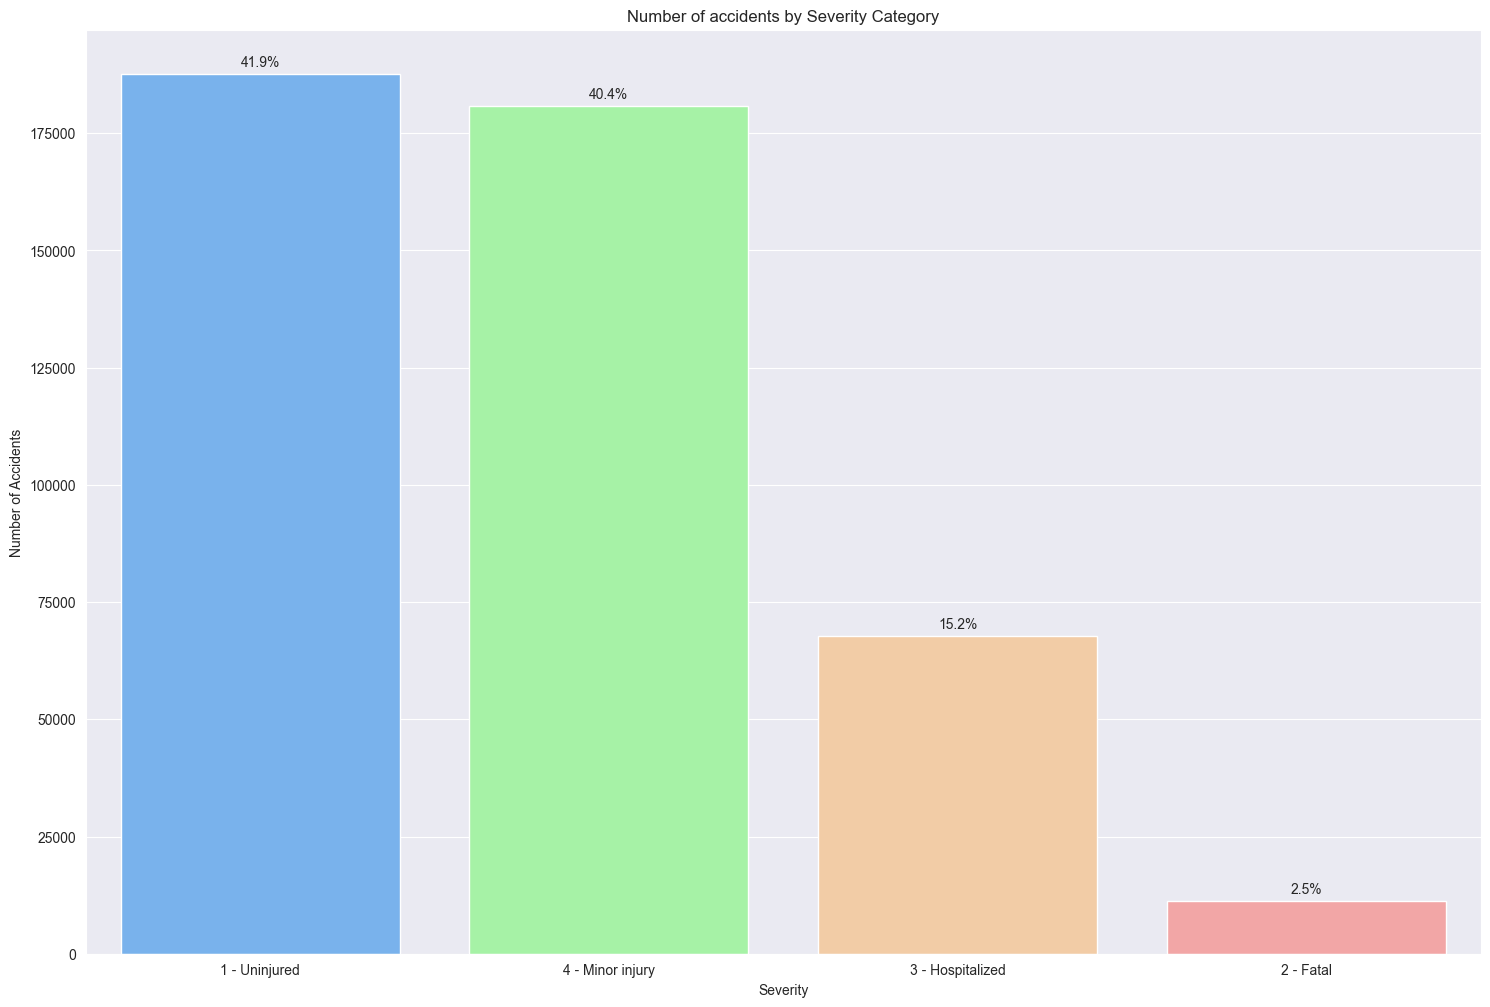

In [10]:
# 1. Number of accidents by Severity Category

# Calculate counts and sort them
counts = data['gravity'].value_counts().sort_values(ascending=False)

# Calculate percentages
total = counts.sum()
percentages = counts / total * 100

plt.figure(figsize=(18, 12))
ax = sns.countplot(data=data, x='gravity', order=counts.index, palette=custom_colors)

for p, percentage in zip(ax.patches, percentages):
    height = p.get_height()
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 8), 
                textcoords='offset points')

plt.title('Number of accidents by Severity Category')
plt.xlabel('Severity')
plt.ylabel('Number of Accidents')
plt.show()

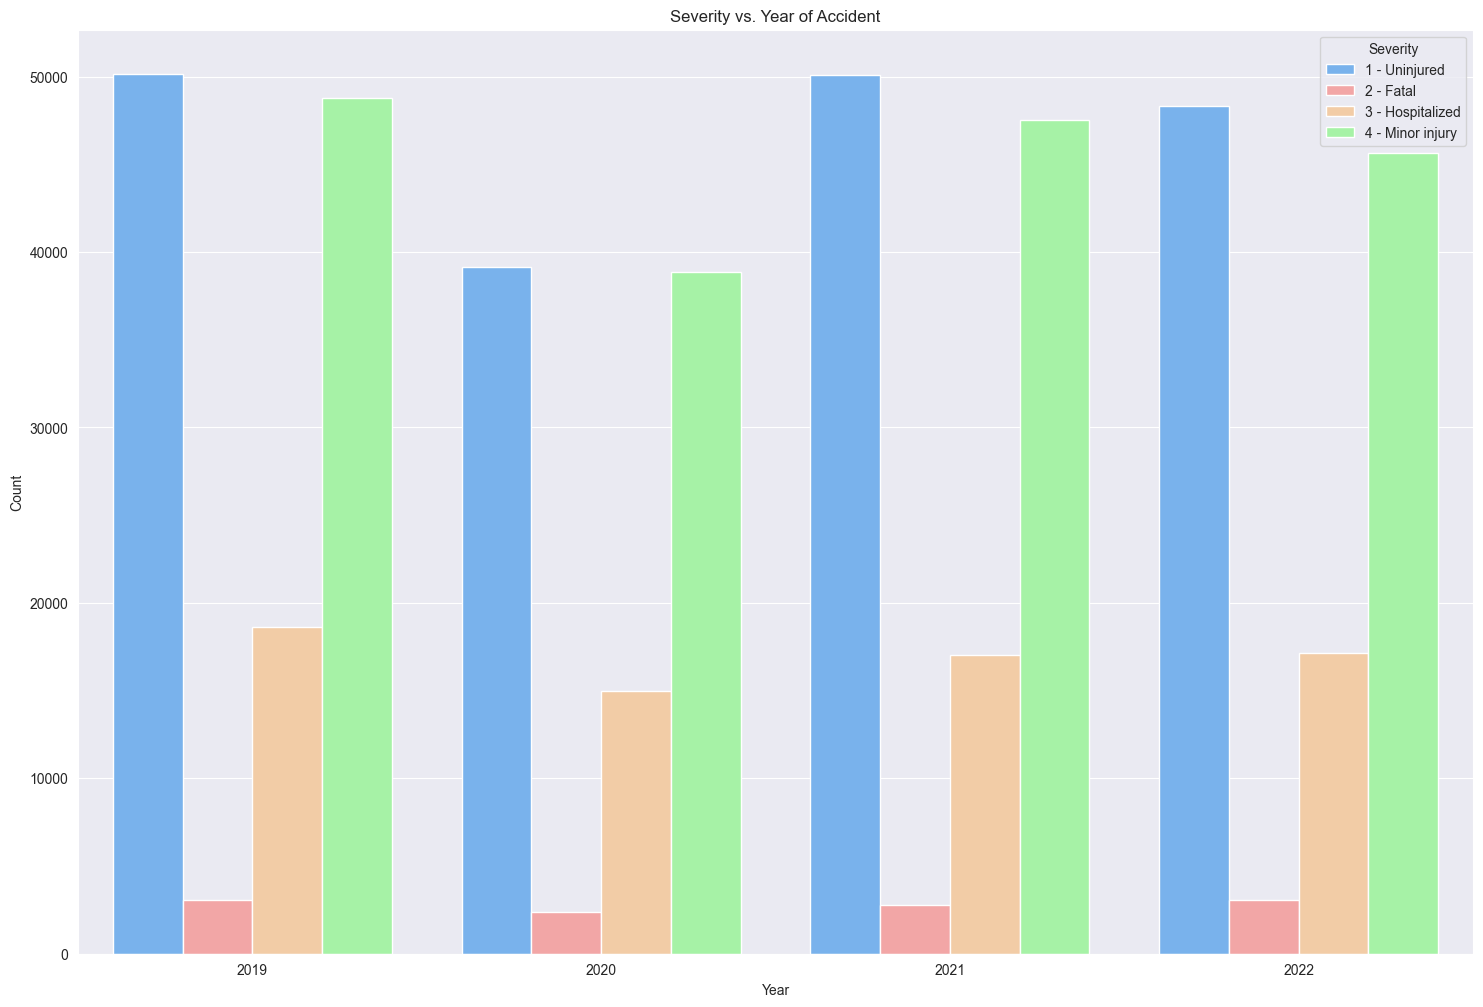

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
year,,,,
2019,41.6%,2.5%,15.5%,40.4%
2020,41.0%,2.5%,15.7%,40.7%
2021,42.6%,2.4%,14.5%,40.5%
2022,42.3%,2.7%,15.0%,40.0%


In [11]:
# 2. Number of accidents by Severity vs.Year
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='year', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Severity vs. Year of Accident')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.show()

# Call function to show the percentage Gravity vs. Year
calculate_and_display_percentages(data, 'year')

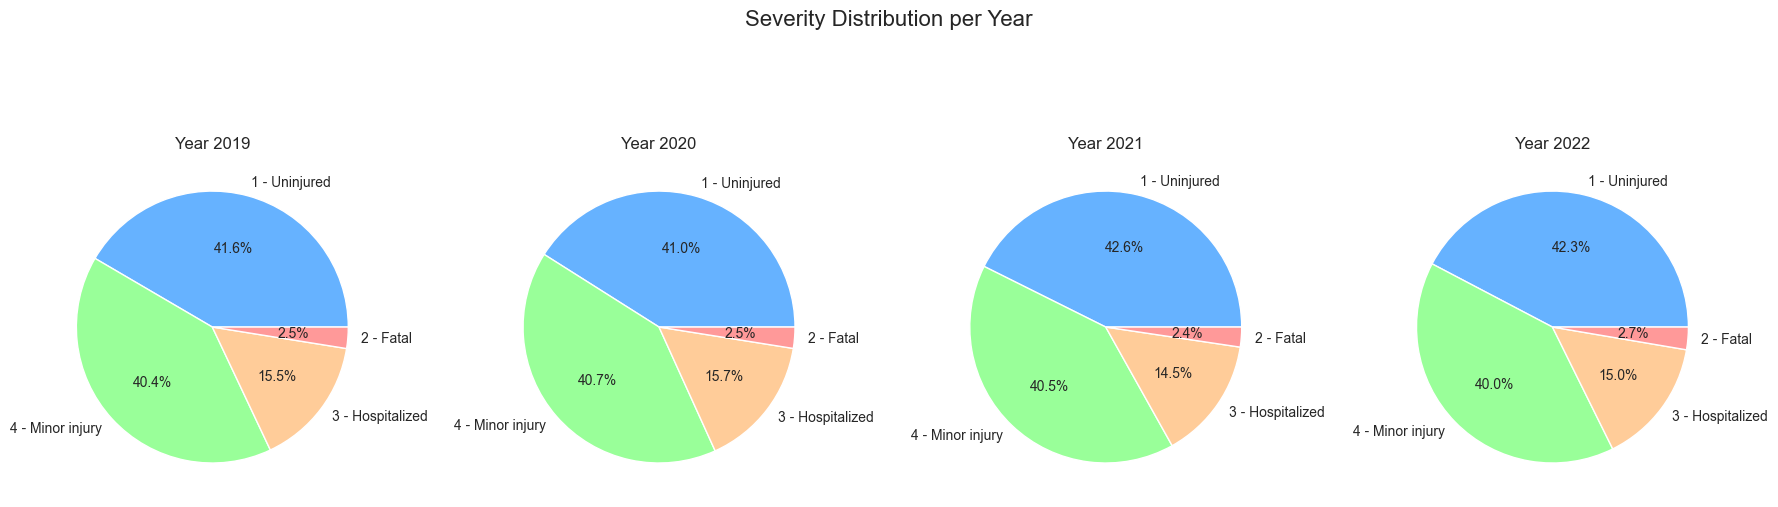

In [12]:
# 2.1 Number of accidents by Severity vs.Year
years = data['year'].unique()
n_years = len(years)

fig, axes = plt.subplots(1, n_years, figsize=(18, 6))
fig.suptitle('Severity Distribution per Year', fontsize=16)

custom_colors_mat = ['#66B2FF', '#99FF99', '#FFCC99', '#FF9999']

for i, year in enumerate(years):
    yearly_data = data[data['year'] == year]['gravity'].value_counts()
    colors = custom_colors_mat[:len(yearly_data)]  
    axes[i].pie(yearly_data, labels=yearly_data.index, autopct='%1.1f%%', colors=colors)
    axes[i].set_title(f'Year {year}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

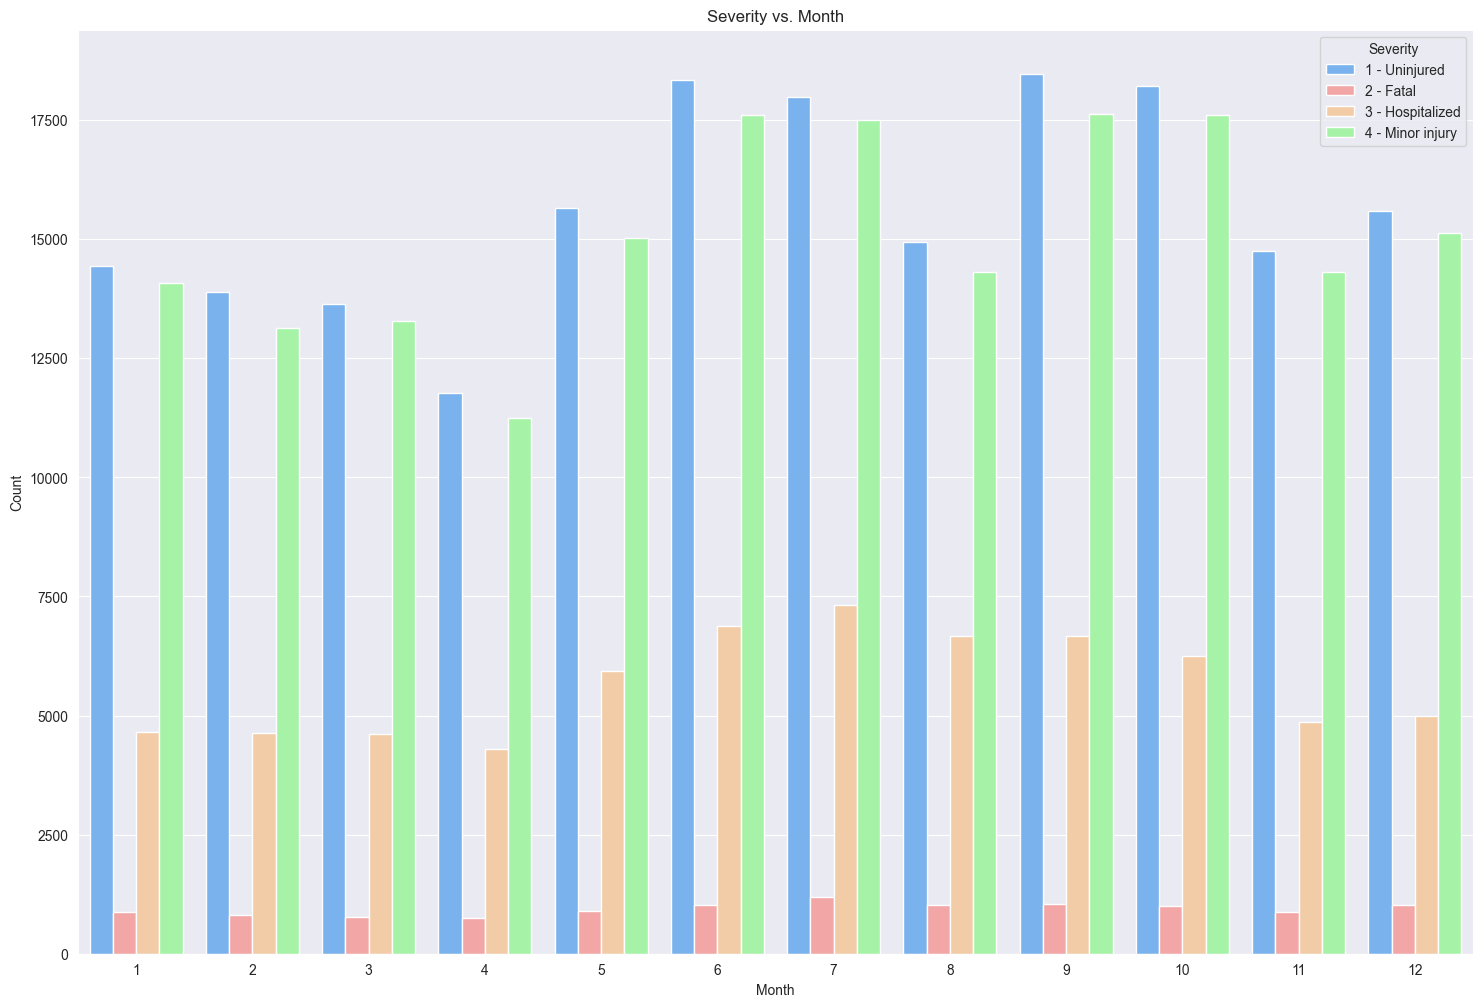

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
month,,,,
1,42.4%,2.6%,13.7%,41.4%
2,42.8%,2.5%,14.2%,40.4%
3,42.2%,2.4%,14.3%,41.1%
4,41.9%,2.7%,15.3%,40.1%
5,41.7%,2.4%,15.8%,40.0%
6,41.8%,2.3%,15.7%,40.1%
7,40.9%,2.7%,16.7%,39.8%
8,40.4%,2.8%,18.1%,38.7%
9,42.2%,2.4%,15.2%,40.2%


In [13]:
# 3. Number of accidents by Severity vs. Month
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='month', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Severity vs. Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.show()

calculate_and_display_percentages(data, 'month')

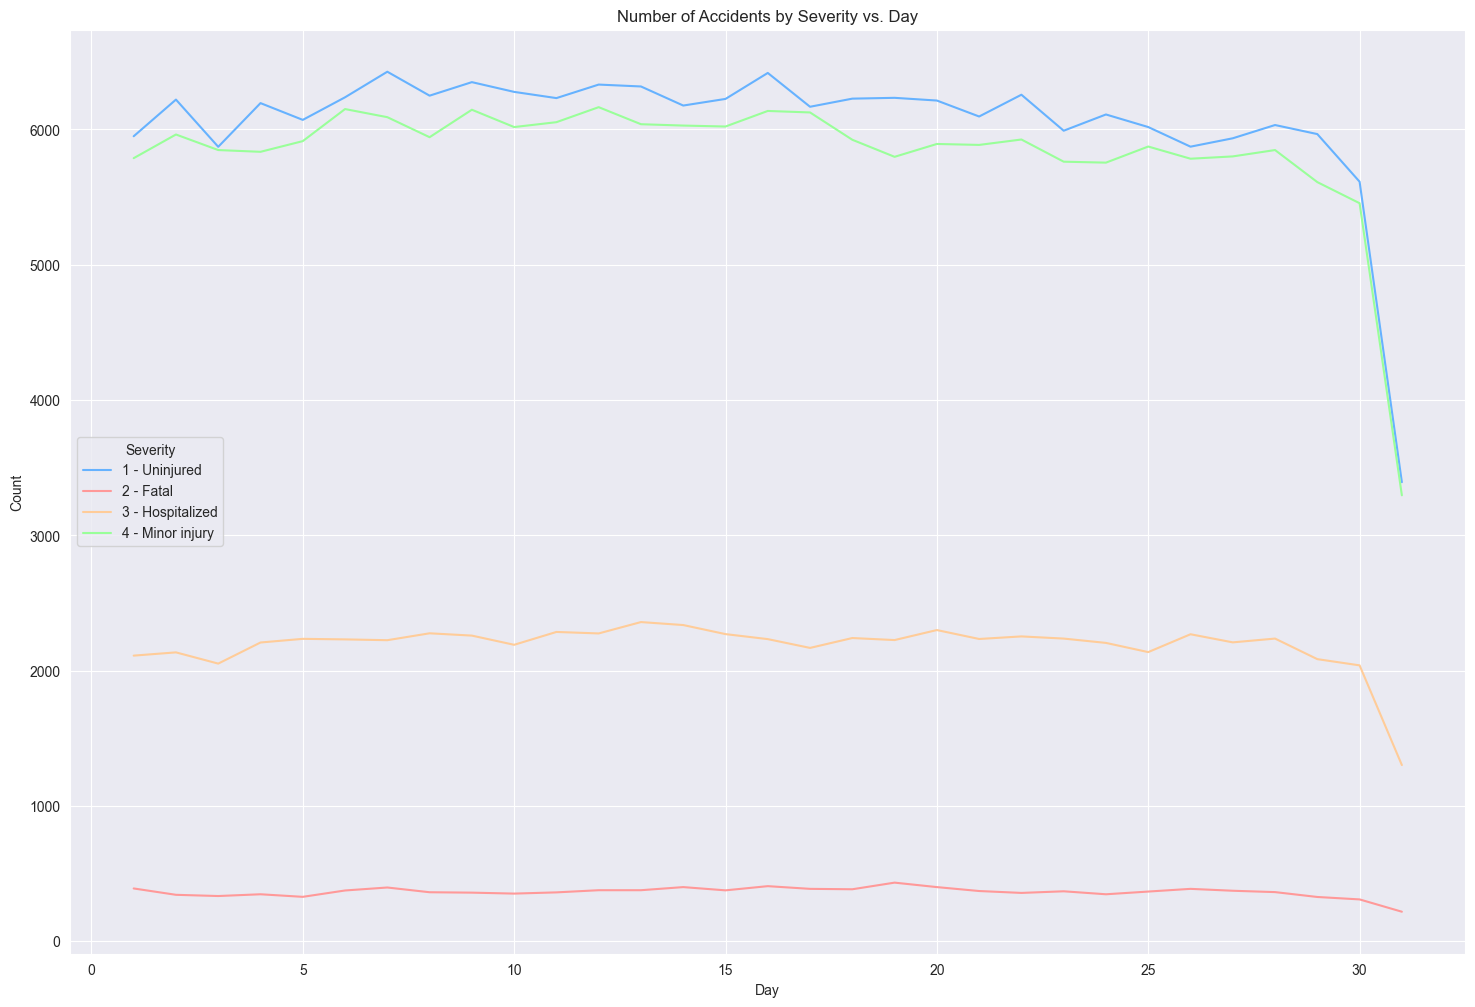

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
day,,,,
1,41.8%,2.7%,14.8%,40.6%
2,42.4%,2.3%,14.6%,40.7%
3,41.6%,2.4%,14.5%,41.5%
4,42.5%,2.4%,15.1%,40.0%
5,41.7%,2.3%,15.4%,40.7%
6,41.6%,2.5%,14.9%,41.0%
7,42.5%,2.6%,14.7%,40.2%
8,42.1%,2.4%,15.3%,40.1%
9,42.0%,2.4%,14.9%,40.7%


In [14]:
# 4. Number of accidents by Severity vs. Day
aggregated_data = data.groupby(['day', 'gravity']).size().reset_index(name='count')

plt.figure(figsize=(18, 12))
sns.lineplot(data=aggregated_data, x='day', y='count', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Number of Accidents by Severity vs. Day')
plt.xlabel('Day')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.show()

calculate_and_display_percentages(data, 'day')

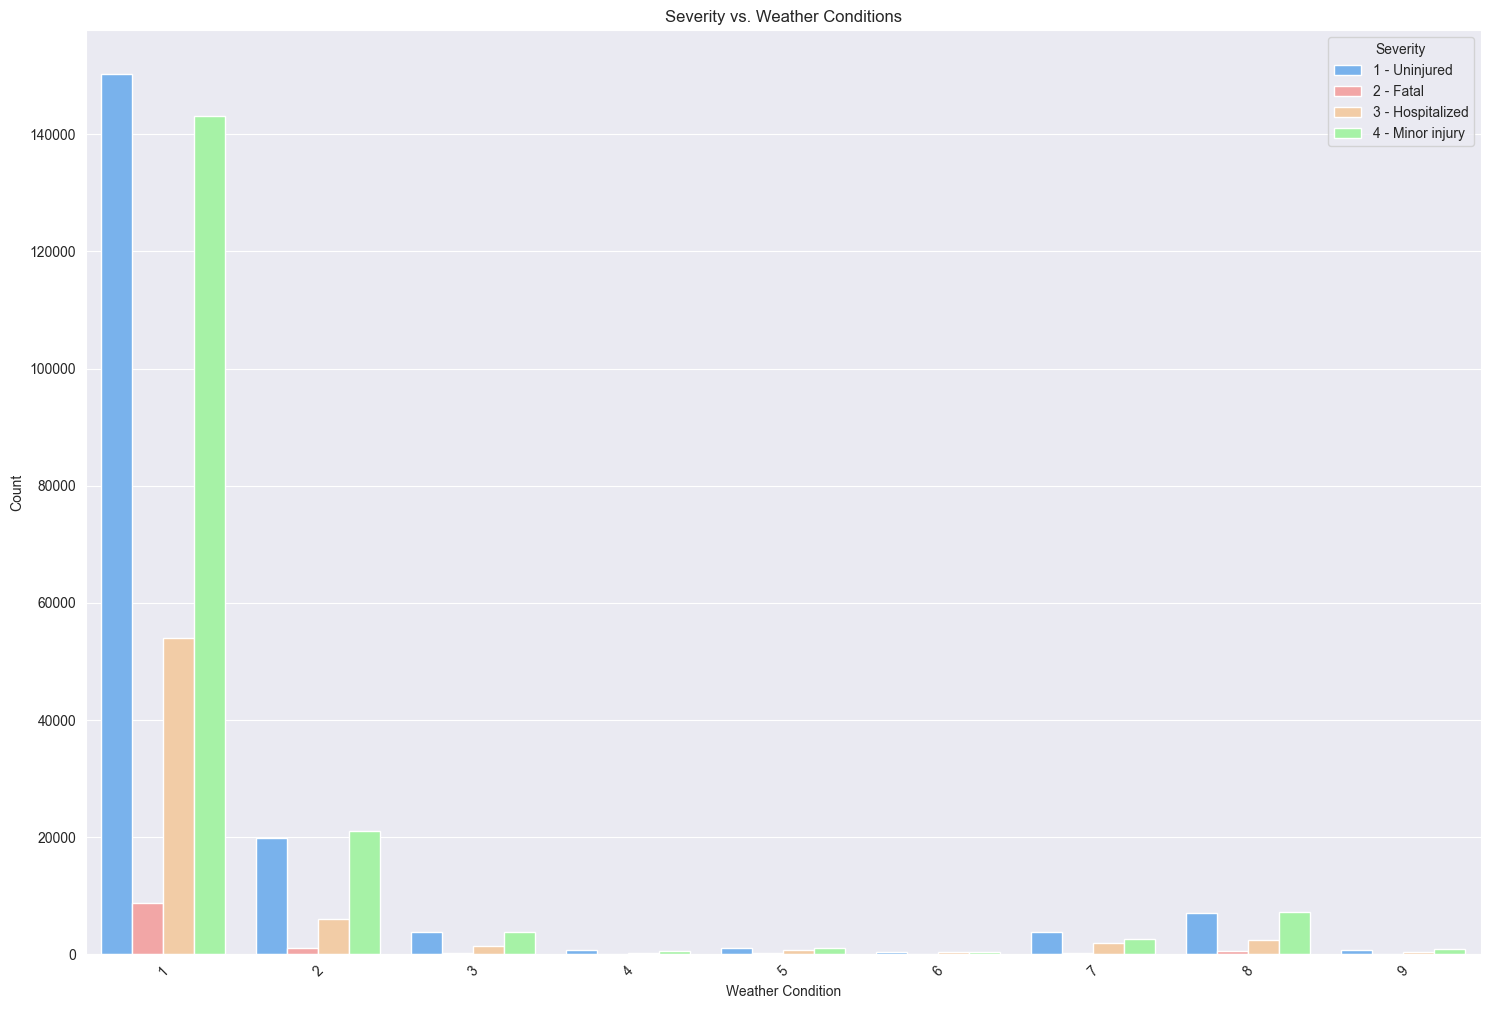

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
atm_condition,,,,
1,42.2%,2.4%,15.2%,40.2%
2,41.2%,2.3%,12.7%,43.9%
3,41.0%,2.5%,15.6%,40.8%
4,43.6%,2.9%,16.2%,37.3%
5,33.4%,5.9%,23.4%,37.3%
6,32.6%,5.5%,26.9%,35.1%
7,44.5%,3.5%,22.5%,29.5%
8,40.8%,3.2%,14.5%,41.5%
9,34.0%,5.5%,20.2%,40.4%


In [15]:
# 5. Number of accidents by Severity vs. Weather Conditions
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='atm_condition', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Severity vs. Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'atm_condition')

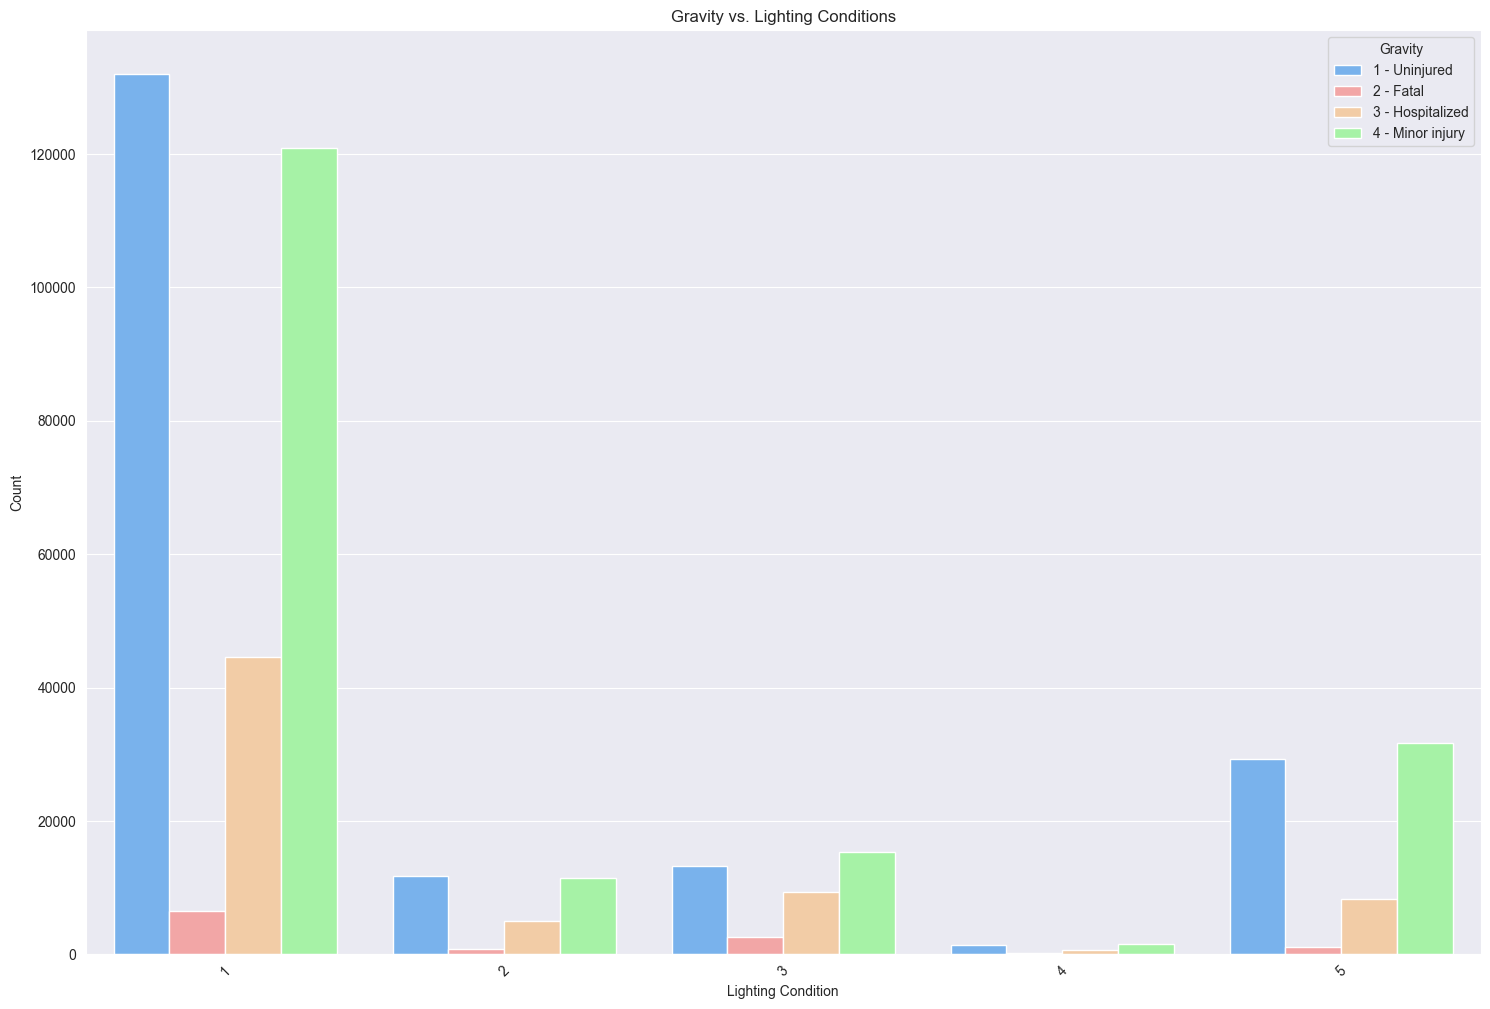

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
lum,,,,
1,43.4%,2.2%,14.7%,39.8%
2,40.5%,2.9%,17.1%,39.5%
3,32.7%,6.4%,23.0%,37.8%
4,37.6%,3.8%,16.0%,42.6%
5,41.6%,1.6%,11.8%,44.9%


In [16]:
# 6. Number of accidents by Severity vs. Lighting Conditions
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='lum', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. Lighting Conditions')
plt.xlabel('Lighting Condition')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'lum')

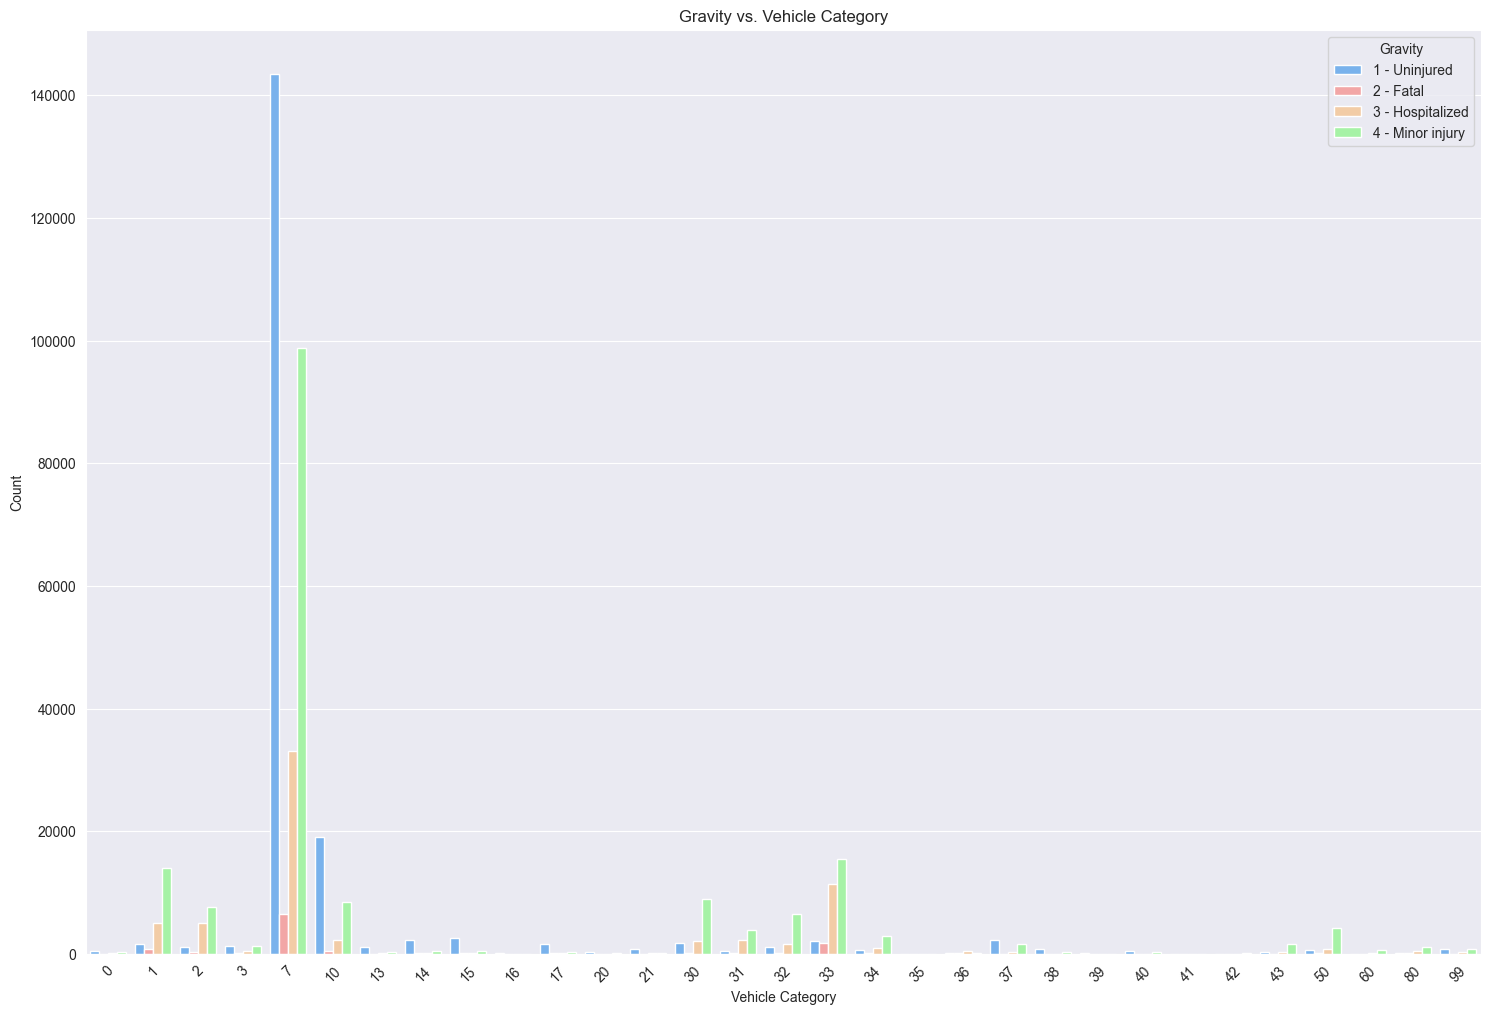

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
vehicle_category,,,,
0,44.0%,3.2%,14.7%,38.0%
1,7.6%,3.5%,23.3%,65.6%
2,7.5%,2.3%,35.7%,54.5%
3,42.5%,2.7%,14.2%,40.7%
7,50.9%,2.3%,11.7%,35.1%
10,62.9%,1.7%,7.5%,27.9%
13,71.1%,1.7%,7.0%,20.2%
14,74.5%,3.4%,7.2%,14.9%
15,78.8%,3.0%,6.7%,11.6%


In [17]:
# 7. Number of accidents by Severity vs. Vehicle Category
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='vehicle_category', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. Vehicle Category')
plt.xlabel('Vehicle Category')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'vehicle_category')

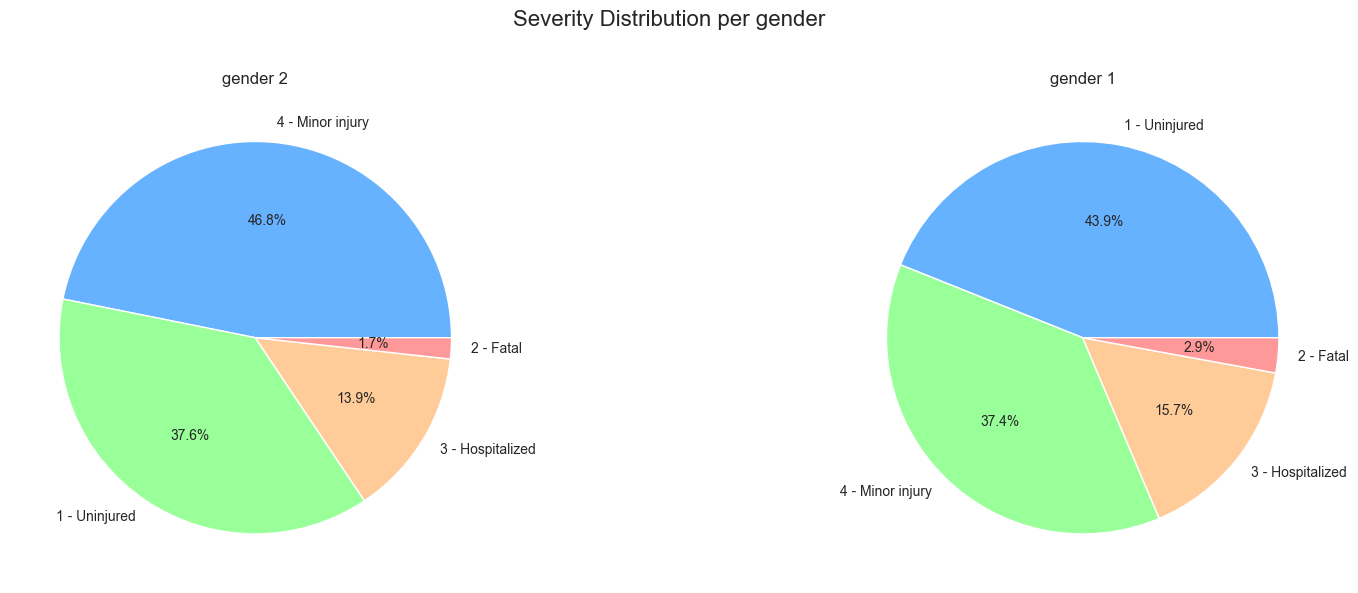

In [18]:
# 7.1 Number of accidents by Severity vs.Year
genders = data['gender'].unique()
n_genders = len(genders)

fig, axes = plt.subplots(1, n_genders, figsize=(18, 6))
fig.suptitle('Severity Distribution per gender', fontsize=16)

custom_colors_mat = ['#66B2FF', '#99FF99', '#FFCC99', '#FF9999']

for i, gender in enumerate(genders):
    genderly_data = data[data['gender'] == gender]['gravity'].value_counts()
    colors = custom_colors_mat[:len(genderly_data)]  
    axes[i].pie(genderly_data, labels=genderly_data.index, autopct='%1.1f%%', colors=colors)
    axes[i].set_title(f'gender {gender}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

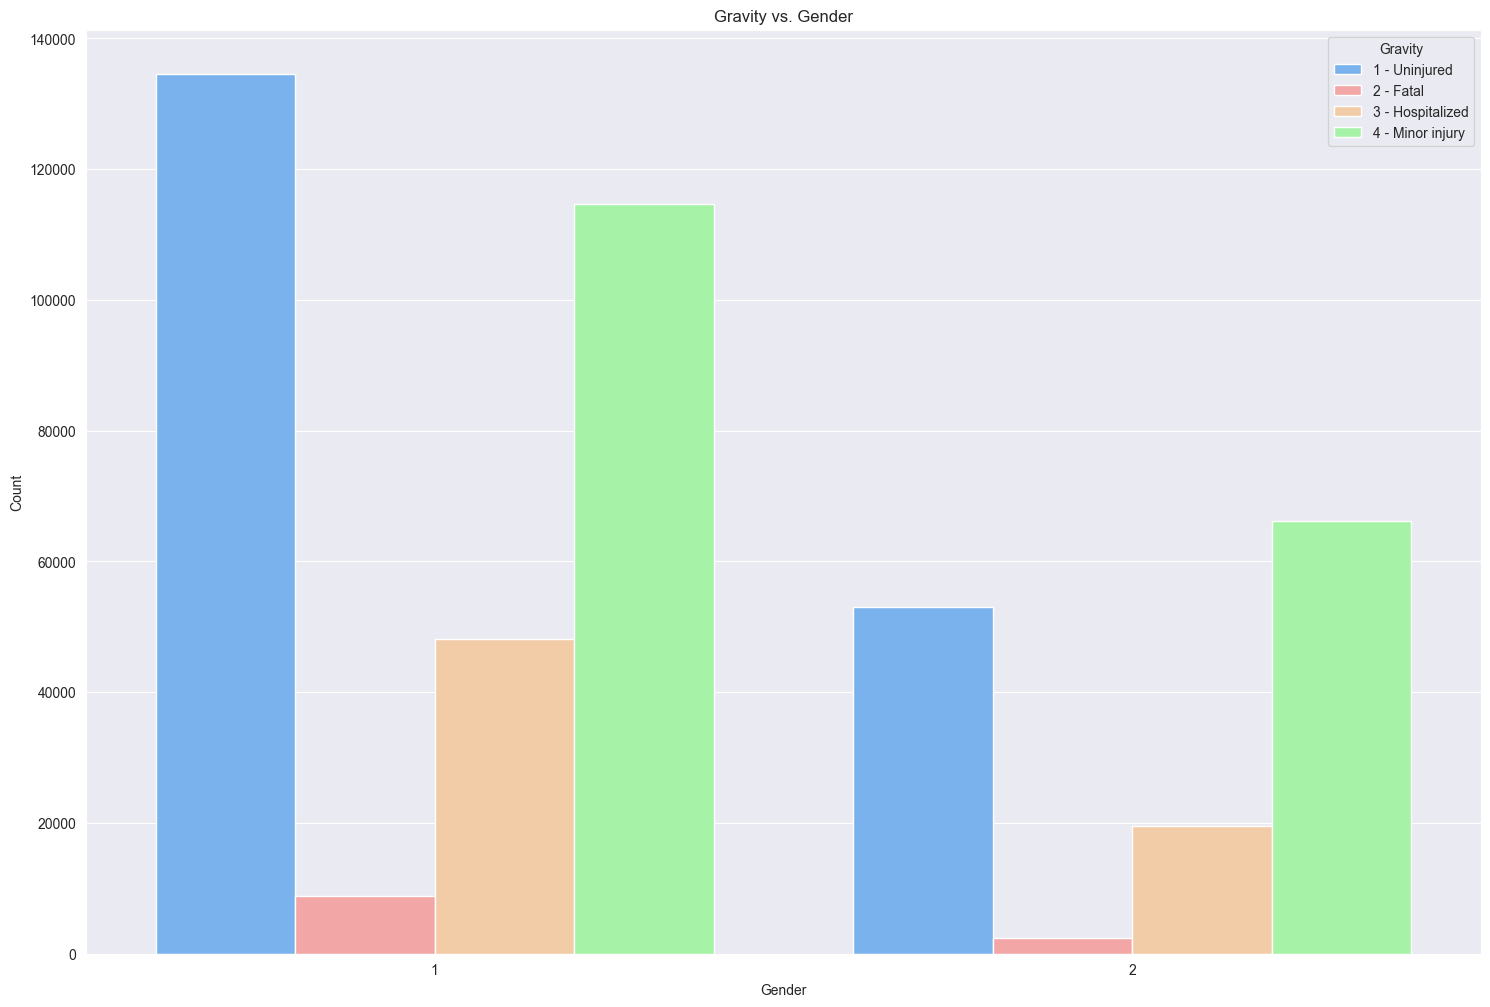

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
gender,,,,
1,43.9%,2.9%,15.7%,37.4%
2,37.6%,1.7%,13.9%,46.8%


In [19]:
# 8. Number of accidents by Severity vs. Gender
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='gender', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.show()

calculate_and_display_percentages(data, 'gender')

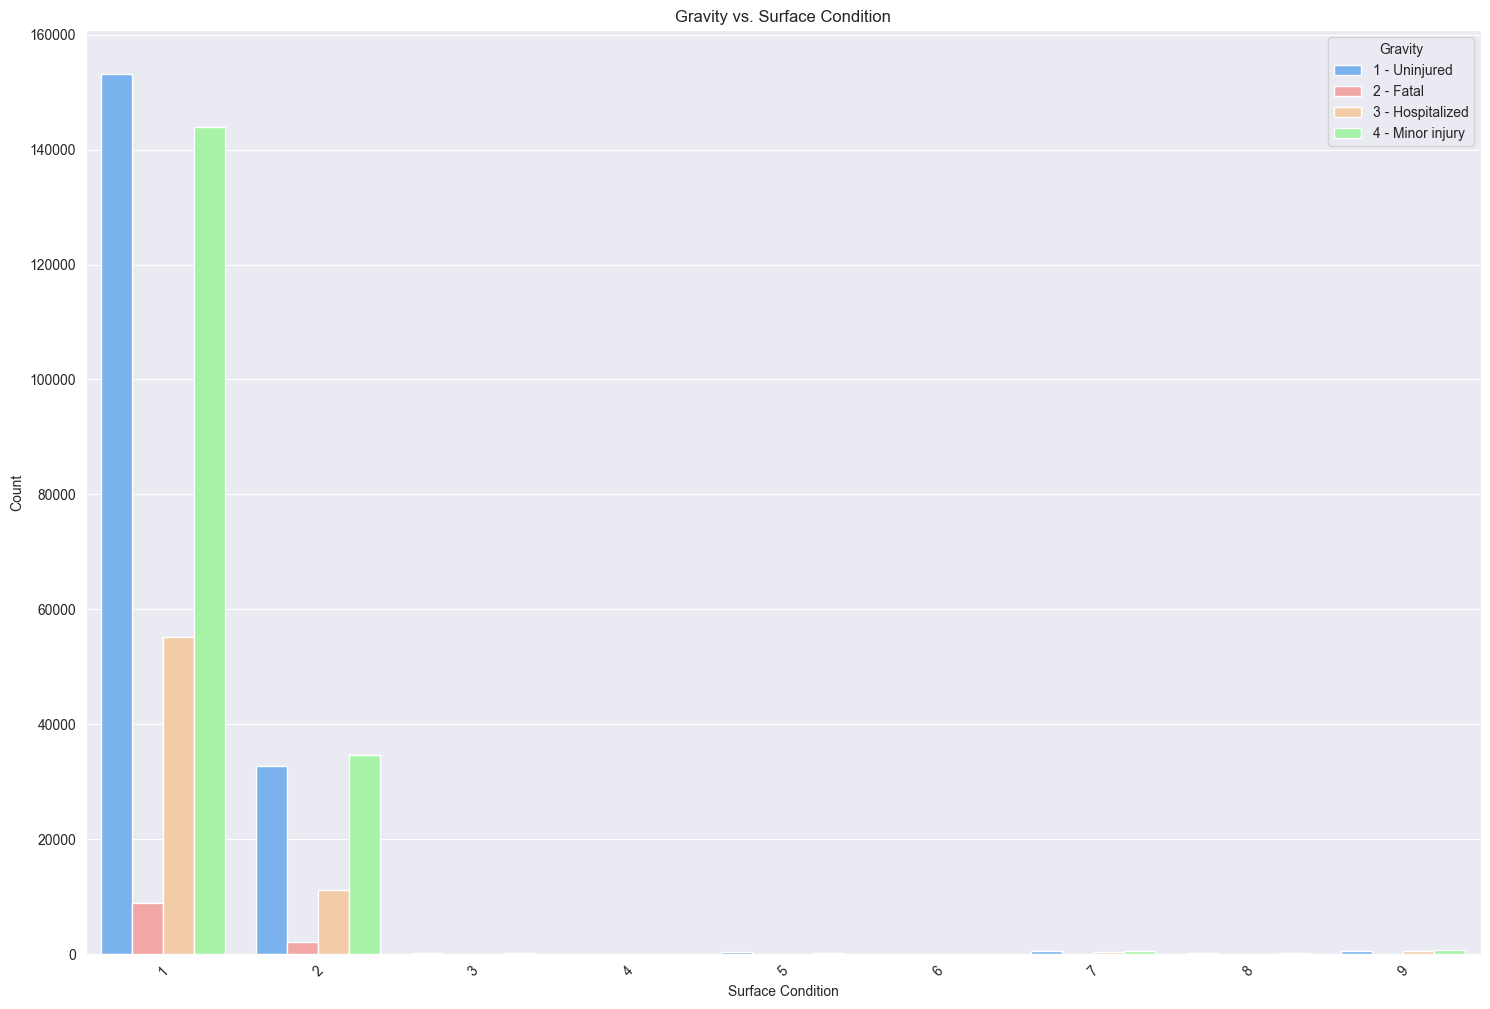

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
surface_condition,,,,
1,42.4%,2.5%,15.3%,39.8%
2,40.6%,2.7%,13.8%,43.0%
3,37.8%,3.1%,19.1%,40.0%
4,37.9%,2.4%,17.8%,42.0%
5,44.2%,2.7%,16.4%,36.6%
6,24.1%,8.9%,36.6%,30.4%
7,30.7%,5.1%,24.4%,39.8%
8,25.2%,1.7%,22.9%,50.3%
9,28.1%,5.2%,29.9%,36.9%


In [20]:
# 9. Number of accidents by Severity vs. Surface Condition
plt.figure(figsize=(18,12))
sns.countplot(data=data, x='surface_condition', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. Surface Condition')
plt.xlabel('Surface Condition')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'surface_condition')

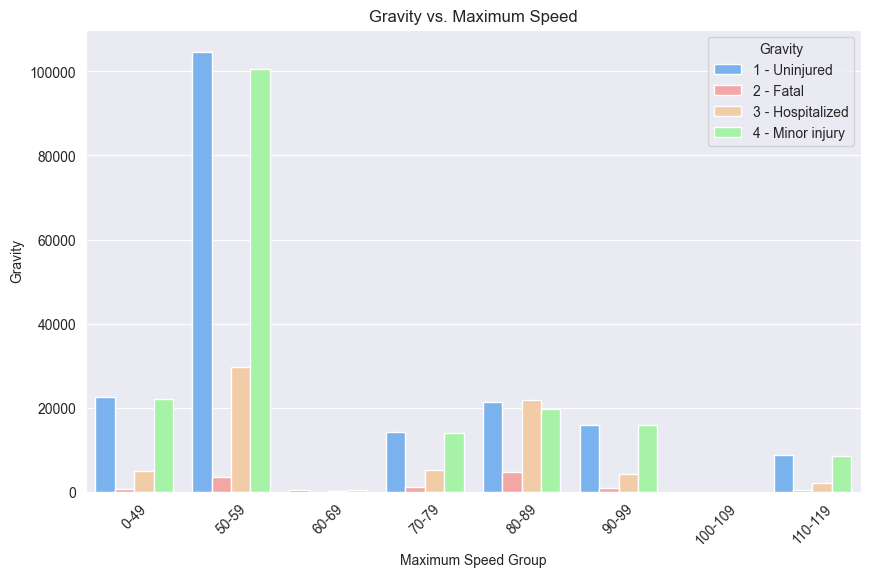

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
maximum_speed,,,,
5,44.1%,1.5%,12.3%,42.2%
6,38.8%,0.0%,12.2%,49.0%
7,50.0%,0.0%,16.7%,33.3%
8,0.0%,0.0%,0.0%,100.0%
9,66.7%,0.0%,0.0%,33.3%
10,44.9%,2.6%,13.5%,39.0%
12,60.0%,0.0%,0.0%,40.0%
15,45.5%,1.8%,12.1%,40.6%
20,42.1%,2.5%,14.6%,40.8%


In [21]:
# 10. Number of accidents by Severity vs. Maximum Speed
# Define the bins and corresponding labels
bins = [0, 49, 59, 69, 79, 89, 99, 109, float('inf')]
labels = ['0-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119']

# Create a new column for the binned speeds
data['speed_group'] = pd.cut(data['maximum_speed'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='speed_group', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. Maximum Speed')
plt.xlabel('Maximum Speed Group')
plt.ylabel('Gravity')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'maximum_speed')

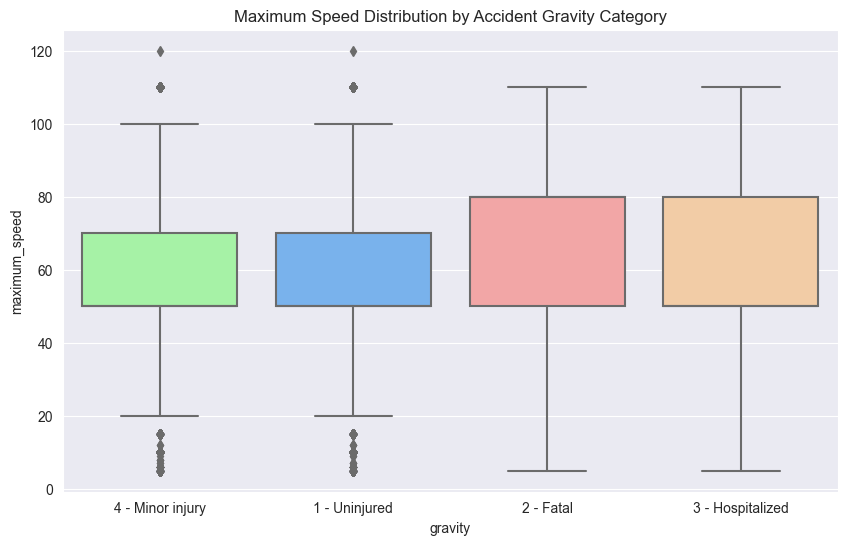

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
maximum_speed,,,,
5,44.1%,1.5%,12.3%,42.2%
6,38.8%,0.0%,12.2%,49.0%
7,50.0%,0.0%,16.7%,33.3%
8,0.0%,0.0%,0.0%,100.0%
9,66.7%,0.0%,0.0%,33.3%
10,44.9%,2.6%,13.5%,39.0%
12,60.0%,0.0%,0.0%,40.0%
15,45.5%,1.8%,12.1%,40.6%
20,42.1%,2.5%,14.6%,40.8%


In [22]:
# 11. Number of accidents by Severity vs. Maximum Speed
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='gravity', y='maximum_speed', hue_order=gravity_order, palette=custom_colors)
plt.title('Maximum Speed Distribution by Accident Gravity Category')
plt.show()

calculate_and_display_percentages(data, 'maximum_speed')

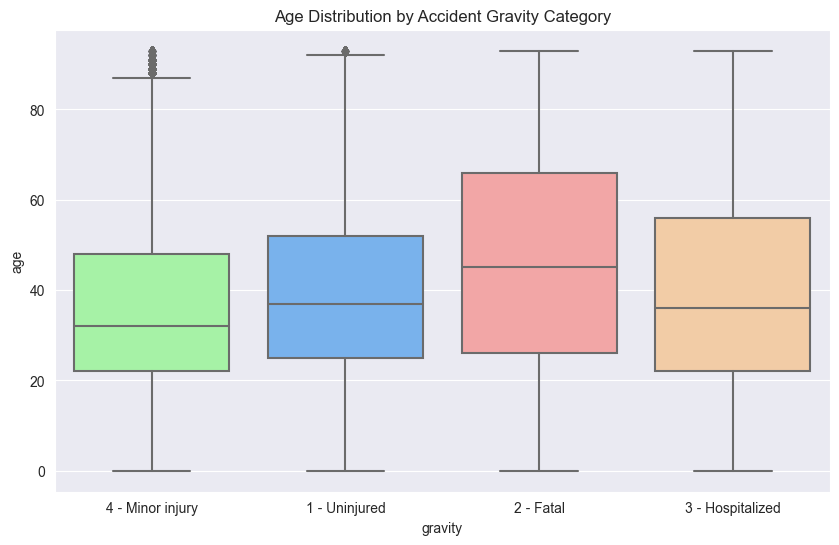

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
age,,,,
0.000000,36.9%,1.5%,8.5%,53.2%
1.000000,44.3%,2.0%,7.2%,46.4%
2.000000,42.8%,1.5%,8.9%,46.8%
3.000000,35.4%,1.3%,11.3%,51.9%
4.000000,32.1%,0.9%,11.5%,55.5%
5.000000,31.0%,1.0%,13.6%,54.5%
6.000000,30.2%,0.9%,14.3%,54.5%
7.000000,29.3%,1.0%,13.4%,56.3%
8.000000,28.7%,1.1%,14.2%,56.1%


In [23]:
# 11. Number of accidents by Severity vs. Age
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='gravity', y='age', hue_order=gravity_order, palette=custom_colors)
plt.title('Age Distribution by Accident Gravity Category')
plt.show()

calculate_and_display_percentages(data, 'age')

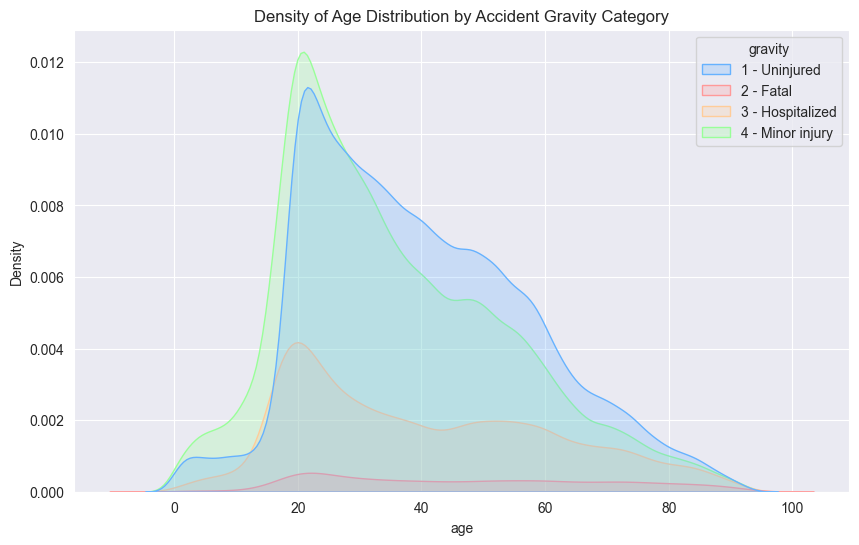

In [24]:
# 12. Number of accidents by Severity vs. Age
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='age', hue='gravity', fill=True, hue_order=gravity_order, palette=custom_colors)
plt.title('Density of Age Distribution by Accident Gravity Category')
plt.show()

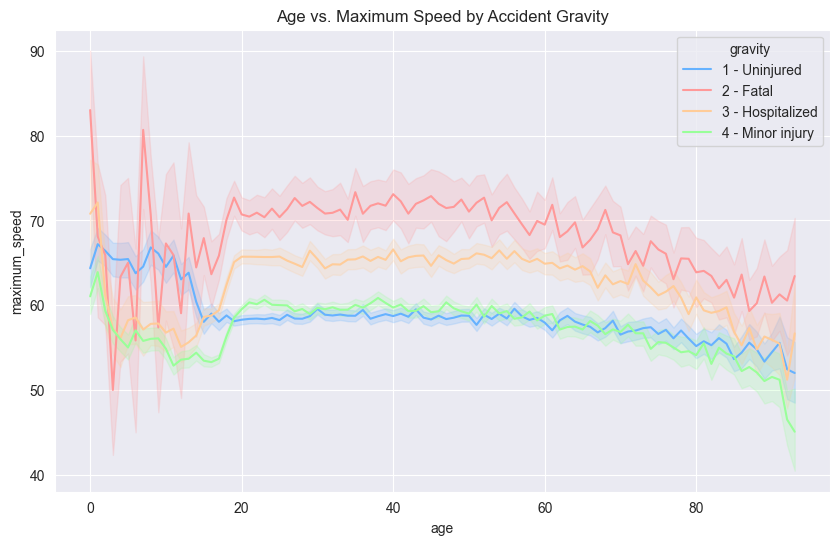

In [25]:
# 13. Number of accidents by Severity vs. Age
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='age', y='maximum_speed', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Age vs. Maximum Speed by Accident Gravity')
plt.show()

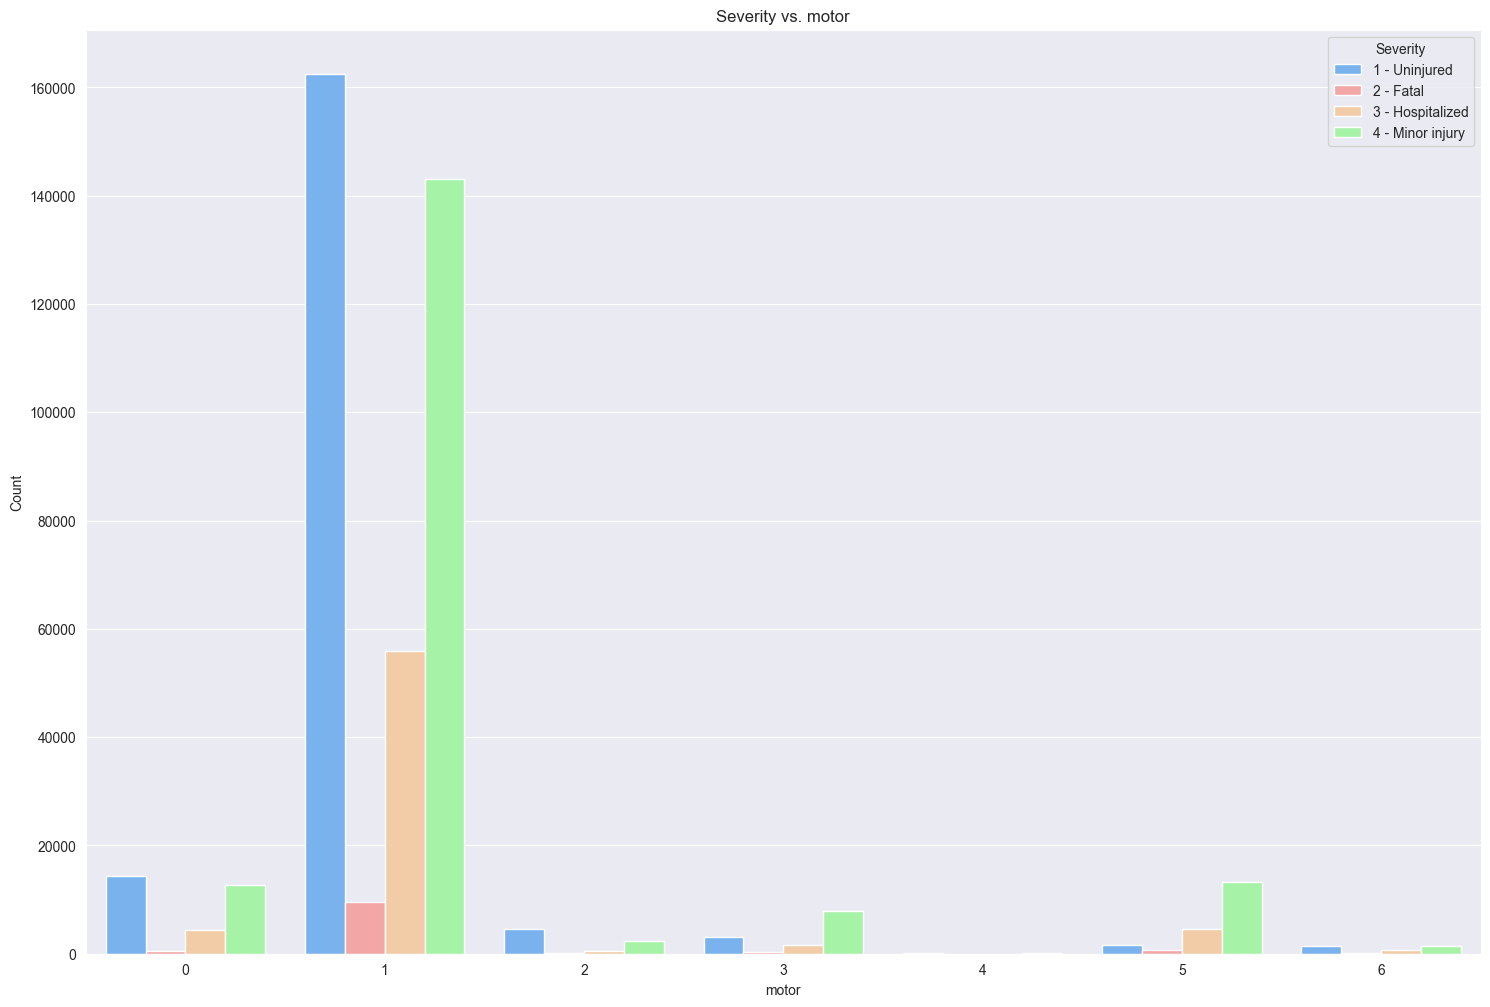

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
motor,,,,
0,44.7%,1.8%,13.8%,39.7%
1,43.8%,2.6%,15.1%,38.6%
2,60.5%,1.1%,6.7%,31.8%
3,23.9%,2.0%,12.8%,61.4%
4,43.6%,0.7%,12.5%,43.3%
5,8.1%,3.3%,23.0%,65.6%
6,39.9%,3.0%,19.0%,38.2%


In [26]:
# 14. Number of accidents by Severity vs. motor
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='motor', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Severity vs. motor')
plt.xlabel('motor')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.show()

calculate_and_display_percentages(data, 'motor')

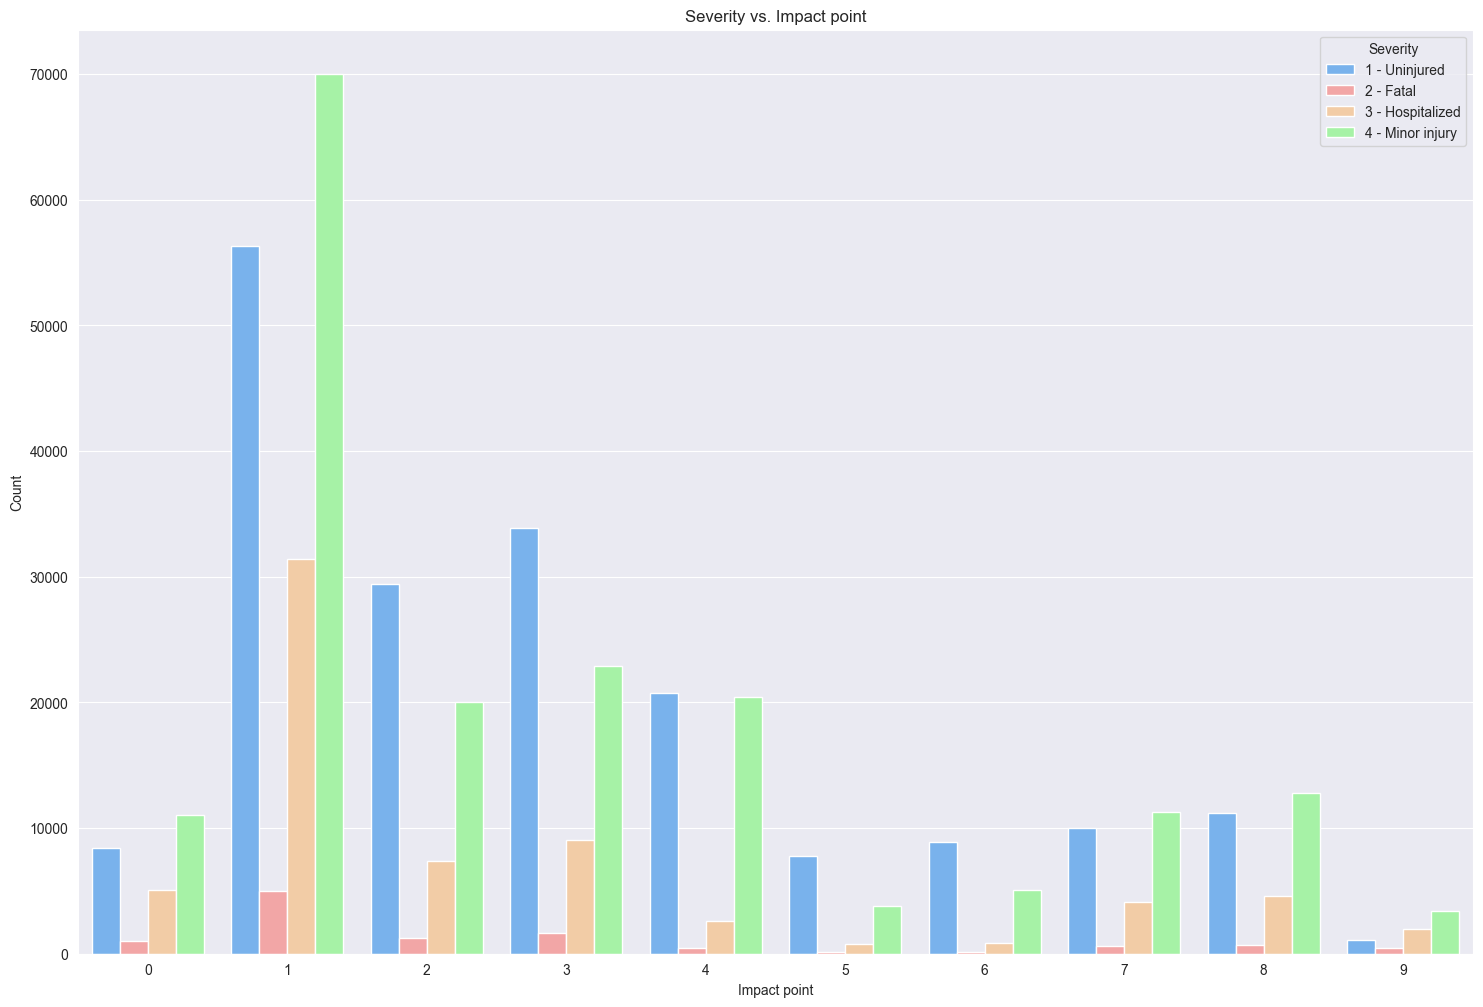

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
initial_impact_point,,,,
0,33.1%,3.8%,19.9%,43.2%
1,34.6%,3.1%,19.3%,43.0%
2,50.7%,2.1%,12.7%,34.5%
3,50.2%,2.4%,13.4%,34.0%
4,46.8%,1.1%,6.0%,46.2%
5,62.2%,0.9%,6.5%,30.4%
6,59.3%,0.7%,5.7%,34.2%
7,38.4%,2.5%,15.7%,43.4%
8,38.3%,2.4%,15.6%,43.7%


In [27]:
# 15. Number of accidents by Severity vs. Impact point
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='initial_impact_point', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Severity vs. Impact point')
plt.xlabel('Impact point')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.show()

calculate_and_display_percentages(data, 'initial_impact_point')

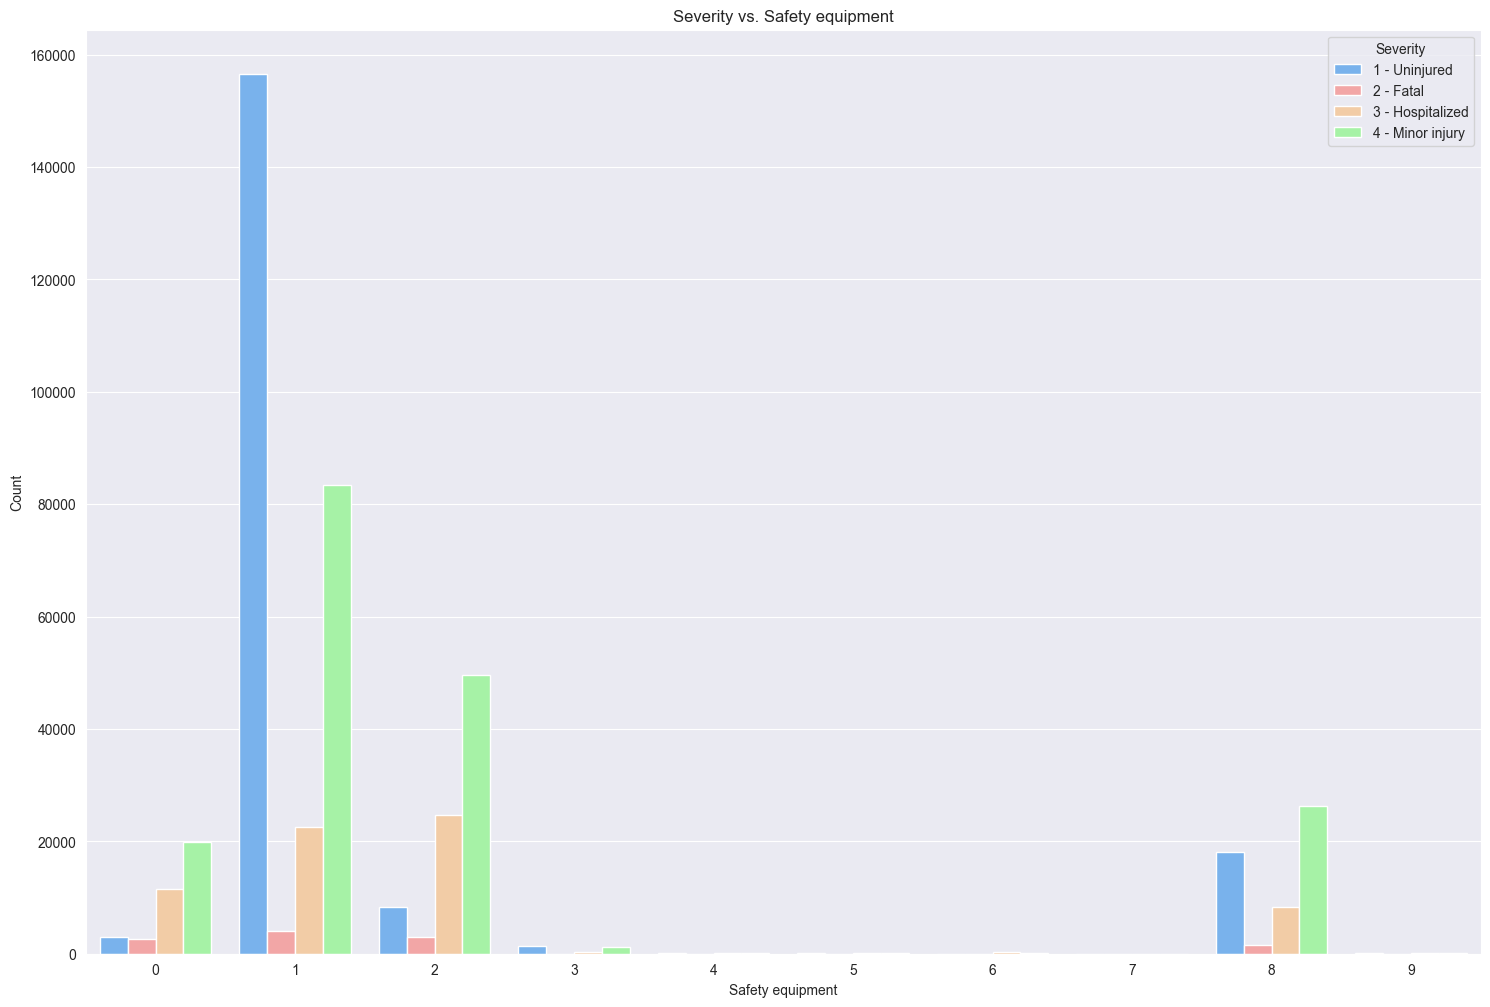

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
safety_equipment1,,,,
0,8.2%,7.2%,30.8%,53.7%
1,58.8%,1.5%,8.5%,31.3%
2,9.6%,3.4%,28.9%,58.1%
3,46.3%,1.2%,8.2%,44.4%
4,16.1%,10.7%,43.6%,29.6%
5,24.9%,9.6%,36.8%,28.7%
6,5.3%,8.0%,58.9%,27.7%
7,7.1%,0.0%,50.0%,42.9%
8,33.4%,2.9%,15.4%,48.3%


In [28]:
# 16. Number of accidents by Severity vs. Safety equipment
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='safety_equipment1', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Severity vs. Safety equipment')
plt.xlabel('Safety equipment')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.show()

calculate_and_display_percentages(data, 'safety_equipment1')

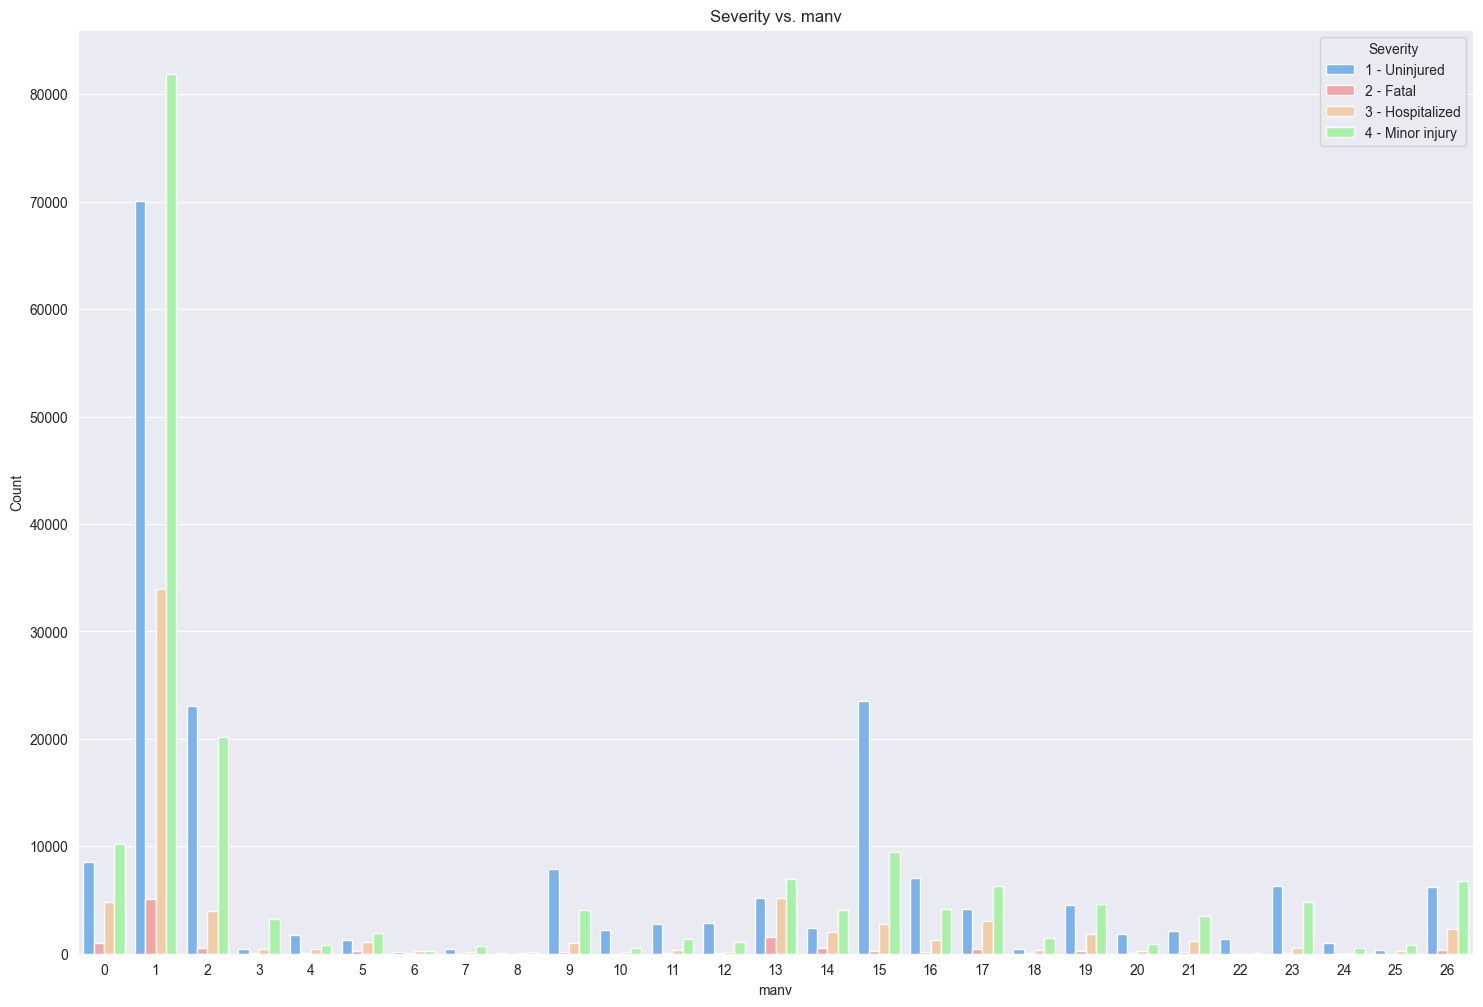

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
manv,,,,
0,34.8%,4.0%,19.7%,41.5%
1,36.7%,2.7%,17.8%,42.9%
2,48.3%,1.1%,8.3%,42.2%
3,9.5%,1.2%,11.4%,77.8%
4,56.6%,2.6%,13.4%,27.4%
5,28.3%,5.6%,24.1%,41.9%
6,27.0%,6.9%,30.1%,35.9%
7,31.1%,1.3%,9.2%,58.4%
8,24.3%,0.5%,16.1%,59.2%


In [29]:
# 17. Number of accidents by Severity vs. Manv
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='manv', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Severity vs. manv')
plt.xlabel('manv')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.show()

calculate_and_display_percentages(data, 'manv')

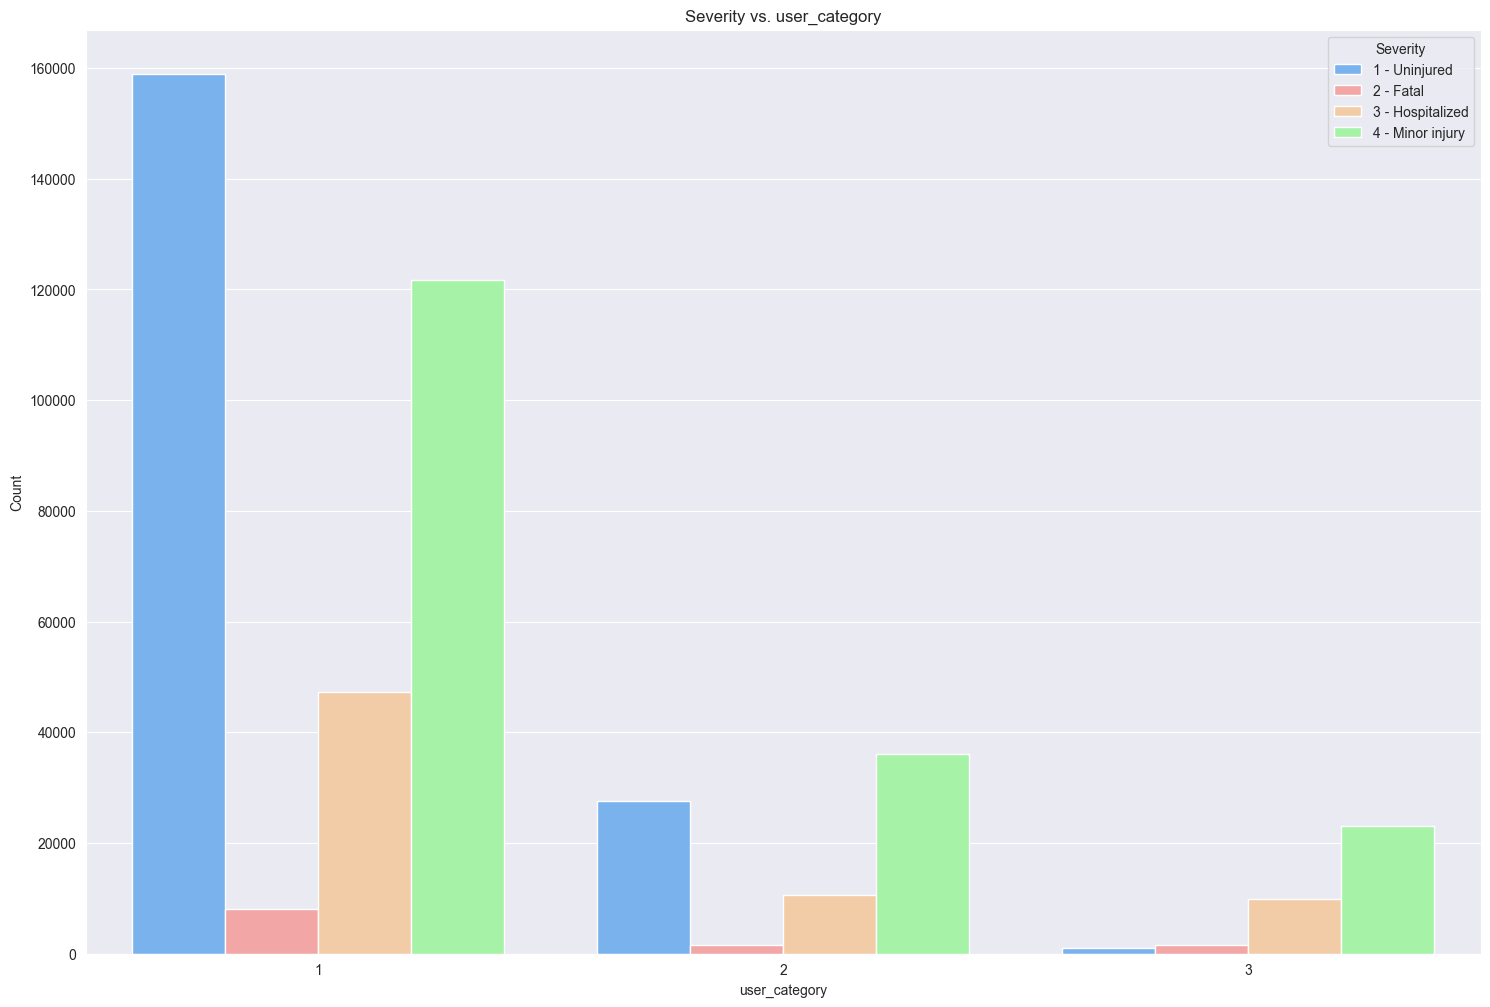

gravity,1 - Uninjured,2 - Fatal,3 - Hospitalized,4 - Minor injury
user_category,,,,
1,47.3%,2.4%,14.1%,36.2%
2,36.4%,2.0%,14.1%,47.5%
3,2.9%,4.6%,27.8%,64.7%


In [30]:
# 18. Number of accidents by Severity vs. user_category
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='user_category', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Severity vs. user_category')
plt.xlabel('user_category')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.show()

calculate_and_display_percentages(data, 'user_category')

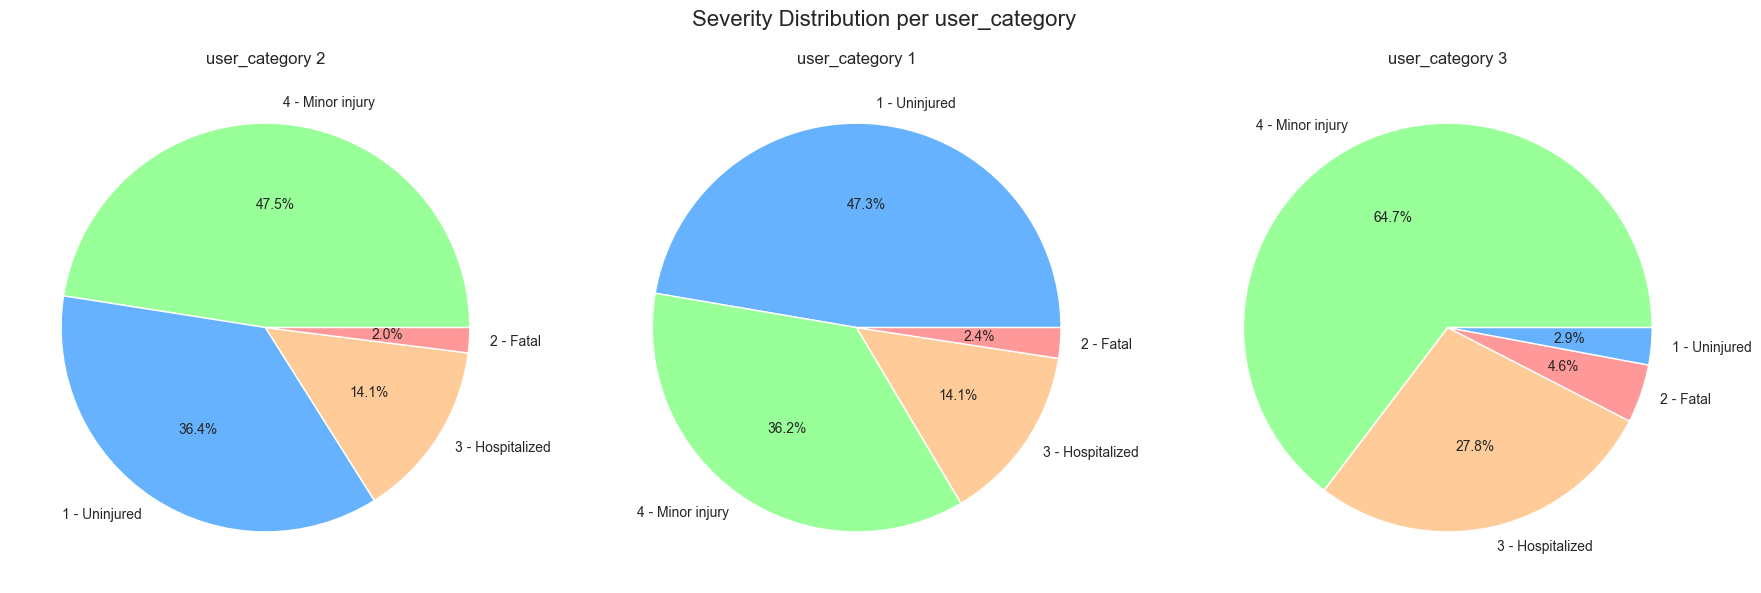

In [34]:
import matplotlib.pyplot as plt

user_categories = data['user_category'].unique()
n_user_categories = len(user_categories)

fig, axes = plt.subplots(1, n_user_categories, figsize=(18, 6))
fig.suptitle('Severity Distribution per user_category', fontsize=16)

# Define a dictionary mapping each gravity category to a specific color
gravity_colors = {
    '1 - Uninjured': '#66B2FF',      
    '2 - Fatal': '#FF9999',       
    '3 - Hospitalized': '#FFCC99',   
    '4 - Minor injury': '#99FF99' 
}

for i, user_category in enumerate(user_categories):
    user_cat_data = data[data['user_category'] == user_category]['gravity'].value_counts()
    colors = [gravity_colors[gravity] for gravity in user_cat_data.index]  # Map gravity to colors
    axes[i].pie(user_cat_data, labels=user_cat_data.index, autopct='%1.1f%%', colors=colors)
    axes[i].set_title(f'user_category {user_category}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# 19. Number of accidents by Severity vs. seat
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='seat', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Severity vs. seat')
plt.xlabel('seat')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.show()

calculate_and_display_percentages(data, 'seat')

In [ ]:
# 20. Number of accidents by Severity vs. fixed_obstacle
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='fixed_obstacle', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. fixed_obstacle')
plt.xlabel('fixed_obstacle')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'fixed_obstacle')

In [ ]:
# 21. Number of accidents by Severity vs. Collision type
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='collision_type', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. Collision type')
plt.xlabel('collision_type')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'collision_type')

In [ ]:
# 22. Number of accidents by Severity vs. plan
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='plan', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. plan')
plt.xlabel('plan')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'plan')

In [ ]:
# 23. Number of accidents by Severity vs. accident situation
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='accident_situation', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. accident situation')
plt.xlabel('accident situation')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'accident_situation')

In [ ]:
# 24. Number of accidents by Severity vs. surface condition
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='surface_condition', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. surface condition')
plt.xlabel('surface condition')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'surface_condition')


In [ ]:
# 25. Number of accidents by Severity vs. longitudinal profile
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='longitudinal_profile', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. longitudinal profile')
plt.xlabel('longitudinal profile')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'longitudinal_profile')

In [ ]:
# 26. Number of accidents by Severity vs. route_category
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='route_category', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. route category')
plt.xlabel('route category')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'route_category')

In [ ]:
# 27. Number of accidents by Severity vs. reason travel
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='reason_travel', hue='gravity', hue_order=gravity_order, palette=custom_colors)
plt.title('Gravity vs. reason_travel')
plt.xlabel('reason_travel')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

calculate_and_display_percentages(data, 'reason_travel')

In [ ]:
# 28. Accidents Severity vs. geographical location
fig = px.scatter_mapbox(
    data, 
    lat="lat", 
    lon="long", 
    color="gravity", 
    color_continuous_scale=px.colors.cyclical.IceFire, 
    zoom=3, 
    height=1000, 
    width=2000, 
    labels={"gravity": "Severity"}
)

# Update the layout for mapbox style
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": data["lat"].mean(), "lon": data["long"].mean()}, 
    title={'x': 0.5} 
)

# Add hover data for more information on each point
fig.update_traces(marker=dict(size=8), 
                  hovertemplate="<br>".join([
                      "Latitude: %{lat}",
                      "Longitude: %{lon}",
                      "Severity: %{marker.color}"
                  ])
)

# Save the map as an HTML file
fig.write_html("accidents_severity_map.html")
